In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from pathlib import Path
from collections import defaultdict
import zarr
import logging
import seaborn as sns
import glob
import os

/home/charles/anaconda3/envs/wbfm/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Validation errors in config file(s).
The following fields have been reset to the default value:

schema_version
  value is not a valid tuple (type=type_error.tuple)



# Functions

In [2]:
def df_from_list(list_of_annotations, col_name_base):
    all_vals = defaultdict(list)
    for proj in list_of_annotations:
        for k, v in proj.items():
            if isinstance(v, list):
                all_vals[k].append(len(v))
                
    all_vals['title'] = [col_name_base] * len(list_of_annotations)

    idx_names = [f'{col_name_base}_{i}' for i in range(len(list_of_annotations))]
    df = pd.DataFrame(all_vals, index=idx_names)
    
    return df

In [3]:
def append_excel_counts_to_dataframe(df_all_datasets, fname, key):
    # New method of loading (append directly to dataframe)
    df = pd.read_excel(fname)
    counts = df['List ID'].value_counts()
    df_all_datasets.loc[key, :] = [int(counts[1]), int(counts[2]), 0, key.split('_')[0]]
    
    return df_all_datasets

In [4]:
def build_dataframe_from_projects_in_folder(folder, key):
    all_dicts = dict()
    index = 0
    for project_path in glob.glob(f"{folder}/*"):
        print(f"Checking: {project_path}")
        if Path(project_path).is_dir():
            fname = os.path.join(project_path, 'visualization', 'selected_neurons.csv')
            if Path(fname).exists():
                dict_key = f"{key}_{index}"                
                
                counts = pd.read_csv(fname)['List ID'].value_counts().to_dict()
                these_counts = [int(counts.get(1, 0)), int(counts.get(2, 0)), 0, key]
                if these_counts[0] == 0:
                    # Then it wasn't actually annotated
                    logging.warning(f"Project {project_path} was not annotated")
                    continue
                else:
                    index += 1
                    all_dicts[dict_key] = these_counts

    df = pd.DataFrame(all_dicts).T
    df.columns = ['high', 'low', 'possible', 'title']
    
    print(f"Found {df.shape[0]} annotated projects")
    
    return df

# Loading all projects

In [5]:
from wbfm.utils.visualization.load_all_projects import *

# Manually annotate which neurons show high, low, or possible activity



High - Can almost certainly get good behavioral correlations. May still show motion artifacts

Low - Probably can't do good correlation based work, but might after additional cleanup. Show low signal, significant artifacts, or lots of gaps

Possible - Can't do work with this without significant cleanup. May be entirely artifact

Also: a description of the level of motion artifacts. 0 = Not visible (none of the datasets); 1 = Low (Many neurons seem undisturbed by artifacts, but they are clear in low signal ones); 2 = Medium (Even neurons with signal have visible artifacts, but they are clearly lower amplitude); 3 = High (Even highest signal neurons have comparible artifacts)

## Original dim

In [6]:
project1_active = dict(
    high = [1, 41, 111, 7, 17, 22, 27, 117, 28, 33, 118, 128, 20],
    low = [6, 16, 21, 36, 71, 47, 122, 142, 13, 68, 105],
    possible = [26, 76, 91, 116, 141, 12, 57, 102, 107, 83, 123, 29, 54, 59, 69, 74, 15, 25, 55, 60, 120, 125],
    motion_artifact_level = 1)

project2_active = dict(
    high = [61, 87, 102, 128, 4, 103, 80],
    low = [66, 62, 97, 3, 8, 93, 108, 118, 9, 24, 34, 93, 74, 94, 15, 40, 95],
    possible = [7, 1, 6, 21, 26, 12, 147, 13, 38, 58, 68, 64, 79, 114, 20, 45, 70, 160],
    motion_artifact_level = 1)


project4_active = dict(
    high = [83],
    low = [88, 103, 119, 40, 70, 65, 130],
    possible = [113, 140, 65, 14, 117],
    motion_artifact_level = 2)

annotations = [project1_active, project2_active, project4_active]
df_dim = df_from_list(annotations, 'original_laser600')

In [7]:
# df_dim

In [8]:
# Not manually annotated

# Round 2 worm 3
project3_active = dict(
    high = [76, 121, 22, 32, 62, 143, 4, 59, 134, 75],
    low = [11, 16, 56, 91, 126, 17, 8, 29, 34, 39, 84, 84, 94, 129, 139, 5, 35, 40, 85],
    possible = [2, 52, 82, 132, 13, 33, 43, 63, 68, 103, 108, 99, 25, 140, 125],
    motion_artifact_level = 1)

# round2 worm4
project5_active = dict(
    high = [30, ],
    low = [1, 138, 24, 138, 64, 15, 85, 145, 155],
    possible = [],
    motion_artifact_level = 1)

# round2 worm4_1
project6_active = dict(
    high = [72, 19],
    low = [11, 136, 57, 63, 19, 64, 124, 135],
    possible = [],
    motion_artifact_level = 1)


annotations = [project1_active, project2_active, project3_active, project4_active, project5_active, project6_active]
df_dim_all = df_from_list(annotations, 'original_laser600')

## Old bright

In [9]:
project_bright1_active = dict(
    high = [1, 46, 26, 72, 117, 8, 23, 33, 38, 29, 39, 139, 55, ],
    low = [6, 11 , 31, 36, 51, 61, 66, 106, 116, 136, 32, 102, 112, 122, 147, 13, 18, 128, 9, 19, 24, 34, 54, 79, 94, 20, 35, 40, 45, 50, 70, 95, 110, 120, 125, 140, 135, 145],
    possible = [31, 7, 47],
    motion_artifact_level = 1)

project_bright2_active = dict(
    high = [41, 91, 2, 62, 146, 20],
    low = [16, 21, 56, 61, 71, 136, 27, 32, 57, 77, 87, 68, 73, 78, 133, 4, 94, 99, 114, 40, ],
    possible = [103, 65, 85, 100, 115, 120, 145, 1, 7, 22, 31, 81, 126, 17, 8, 138],
    motion_artifact_level = 3)

annotations = [project_bright1_active, project_bright2_active]
df_bright = df_from_list(annotations, 'december_laser800')

In [10]:
# Not manually annotated

# Bright6
project_bright3_active = dict(
    high = [6, 26, 61, 61, 116, 102, 33, 43, 78, 108, 4, 39, 109, 70, 140, 4],
    low = [86, 71, 111, 121, 141, 2, 27, 22, 77, 112, 137, 58, 108, 14, 24, 29, 34, 44, 94, 119, 10, 20, 25, 35, 30, 45, 55, 60, 90, 100, 105, 135],
    possible = [],
    motion_artifact_level = 1)

annotations = [project_bright1_active, project_bright2_active, project_bright3_active]
df_bright_all = df_from_list(annotations, 'december_laser800')

## New bright

In [11]:
# None manually annotated

project_bright_C1_active = dict(
    high = [138, 13, 86, ],
    low = [41, 112, 113, ],
    possible = [],
    motion_artifact_level = 1)

project_bright_C2_active = dict(
    high = [7, 22, 68, 83, 19, 105, 135, 59],
    low = [73, 98, 54, 74, 69, 35, 70, 100, 140],
    possible = [],
    motion_artifact_level = 2)

project_bright_C3_active = dict(
    high = [17, 38, 64, ],
    low = [6, 31, 72, 56, 103, 4, 25, 100, 125],
    possible = [],
    motion_artifact_level = 1)

project_bright_C4_active = dict(
    high = [11, 26, 86, 17, 62, 3, 8, 64, 25, 60, ],
    low = [6, 16, 96, 111, 47, 33, 4, 29, 49, 89, 104, 129, 75, 95, 100, 120],
    possible = [],
    motion_artifact_level = 1)


annotations = [project_bright_C1_active, project_bright_C2_active, project_bright_C3_active, project_bright_C4_active]
df_bright_new = df_from_list(annotations, 'new_laser800')

## Exposure 12ms

In [12]:
project_12exp1_active = dict(
    high = [111, 126, 48, 44, 54, 59, 119, 25, 40, 45, 50],
    low = [6, 141, 7, 22, 92, 127, 142, 123, 109, 35, 105, 135],
    possible = [],
    motion_artifact_level = 1)

project_12exp2_active = dict(
    high = [11, 41, 71, 96, 116, 106, 7, 17, 3, 43, 53, 58, 63, 143, 9, 14, 19, 24, 29, 74, 85],
    low = [26, 36, 46, 81, 91, 136, 146, 2, 12, 42, 67, 72, 38, 28, 73, 108, 153, 4, 79, 124, 10, 20, 65, 90, 95, 120, 130, 150],
    possible = [],
    motion_artifact_level = 1)

project_12exp3_active = dict(
    high = [46, 61, 81, 122, 3, 28, 118, 49, 74, 135],
    low = [6, 36, 96, 101, 126, 52, 57, 97, 8, 58, 63, 9, 4, 104, 94, 119, 144, 20, 10, 5, 40, 25, 75, 90, 100, 145, 155],
    possible = [],
    motion_artifact_level = 1)

project_12exp4_active = dict(
    high = [16, 66, 91, 7, 42, 18, 33, 63, 93, 133, 79, ],
    low = [21, 26, 121, 126, 72, 82, 97, 157, 147, 43, 48, 58, 68, 73, 143, 4, 9, 14, 104, 99, 5, 25, 125, 120],
    possible = [],
    motion_artifact_level = 1)

project_12exp6_active = dict(
    high = [21, 31, 76, 131, 186, 115, 10, 85, 94],
    low = [11, 56, 96, 151, 196, 127, 172, 182, 207, 3, 18, 53, 88, 163, 4, 134, 10, 85, 75, 60, ],
    possible = [],
    motion_artifact_level = 2)

project_12exp11_active = dict(
    high = [46, 56, 81, 106, 17, 47, 57, 97, 122, 157, 13, 23, 58, 83, 39, 44, 59, 69, 30, 80, 100, 110],
    low = [16, 86, 146, 32, 72, 82, 132, 8, 68, 78, 98, 4, 14, 64, 74, 139, 30, 15, 105],
    possible = [],
    motion_artifact_level = 1)

project_12exp12_active = dict(
    high = [31, 66, 106, 121, 22, 37, 23, 33, 63, 118, 14, 84, 119, 5, 35, 40, 75, 85, 90, 95, 130, 119],
    low = [1, 6, 56, 61, 81, 101, 141, 2, 7, 67, 82, 87, 92, 97, 152, 3, 8, 48, 93, 4, 49, 79, 84, 94, 25, 30, 50, 80, 140],
    possible = [],
    motion_artifact_level = 1)

annotations = [project_12exp1_active, project_12exp2_active, project_12exp3_active, project_12exp4_active, project_12exp6_active, project_12exp11_active, project_12exp12_active]
df_exp12 = df_from_list(annotations, 'exp12')

In [13]:
project_12exp3_active = dict(
    high = [],
    low = [],
    possible = [],
    motion_artifact_level = 1)

## Double gcamp

In [14]:
project_1_2gcamp_6ms = dict(
    high = [101, 111, 121, 126, 7, 12, 87, 97, 137, 78, 123, 34, 59, 84, 94, 104, 159, 10, 35, 75, 80, 130],
    low = [1, 11, 16, 21, 26, 31, 92, 43, 44, 69, 74, 79, 15, 65, 110, 125],
    possible = [],
    motion_artifact_level = 1)

project_2_2gcamp_6ms = dict(
    high = [61, 86, 136, 2, 17, 23, 28, 98, 113, 4, 29, 49, 59, 84, 15, 75, 100, 110, 130],
    low = [1, 11, 21, 26, 101, 111, 146, 7, 27, 118, 163, 9, 50, 55, 80],
    possible = [],
    motion_artifact_level = 1)


annotations = [project_1_2gcamp_6ms, project_2_2gcamp_6ms]
df_2gcamp_6ms = df_from_list(annotations, 'gcamp2_exp6')

In [15]:
project_1_2gcamp_12ms = dict(
    high = [6, 16, 61, 76, 81, 86, 91, 116, 121, 32, 72, 28, 53, 4, 19, 39, 10, 30, 35, 40, 45, 70, 90, 115],
    low = [11, 51, 56, 66, 37, 102, 137, 38, 83, 118, 74, 114, 134, 5, 25, 65, 110],
    possible = [],
    motion_artifact_level = 1)

project_2_2gcamp_12ms = dict(
    high = [1, 2, 27, 102, 117, 18, 4, 49, 84, 35, 90, 105, 130, 34],
    low = [6, 51, 106, 111, 42, 47, 127, 142, 172, 83, 103, 9, 59, 89, 139, 55, 85, 110],
    possible = [],
    motion_artifact_level = 1)


annotations = [project_1_2gcamp_12ms, project_2_2gcamp_12ms]
df_2gcamp_12ms = df_from_list(annotations, 'gcamp2_exp12')

## Gcamp7b

In [16]:
project_1_gcamp7b = dict(
    high = [6, 31, 36, 91, 111, 136, 176, 32, 57, 67, 87, 92, 18, 94, 35, 65, 85],
    low = [1, 51, 101, 92, 102, 132, 3, 68, 223, 80, 125, 150, 200],
    possible = [],
    motion_artifact_level = 1)

project_data3_gcamp7b = dict(
    high = [6, 41, 46, 66, 71, 81, 111, 116, 2, 12, 32, 47, 57, 117, 3, 23, 58, 68, 98, 133, 29, 39, 79, 10, 30, 35, 55, 60, 85, 95],
    low = [1, 61, 146, 17, 27, 77, 87, 97, 122, 147, 142, 53, 78, 83, 123, 153, 4, 9, 54, 109, 114, 5, 45, 80, 125, 135 ],
    possible = [],
    motion_artifact_level = 1)

project_data4_gcamp7b = dict(
    high = [36, 51, 66, 86, 101, 17, 27, 32, 42, 52, 67, 82, 92, 97, 102, 3, 38, 68, 78, 93, 113, 143, 9, 24, 34, 79, 99, 144, 10, 15, 35, 95, 150],
    low = [16, 21, 26, 12, 107, 58, 88, 138, 4, 30, 20, 140],
    possible = [],
    motion_artifact_level = 1)

project_data5_gcamp7b = dict(
    high = [36, 51, 61, 81, 156, 7, 12, 42, 67, 87, 122, 132, 3, 18, 9, 14, 15, 55, 75, 135],
    low = [6, 31, 126, 151, 17, 37, 48, 58, 153, 24, 69, 99, 159, 40, 115, 140, 150],
    possible = [],
    motion_artifact_level = 1)

In [17]:
annotations = [project_1_gcamp7b, project_data3_gcamp7b, project_data4_gcamp7b, project_data5_gcamp7b]
df_gcamp7b = df_from_list(annotations, 'gcamp7b')

# New method of loading (append directly to above)
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/gcamp7b_sharpened/ZIM2165_Gcamp7b_worm6-2022_10_14_sharpened_1_10/visualization/selected_neurons.xlsx"
key = 'gcamp7b_4'
df_gcamp7b = append_excel_counts_to_dataframe(df_gcamp7b, fname, key)

fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/gcamp7b_sharpened/ZIM2165_Gcamp7b_worm7-2022_10_14_sharpened_1_10/visualization/selected_neurons.xlsx"
key = 'gcamp7b_5'
df_gcamp7b = append_excel_counts_to_dataframe(df_gcamp7b, fname, key)

fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/gcamp7b_sharpened/ZIM2165_Gcamp7b_worm9-2022_10_14_sharpened_1_10/visualization/selected_neurons.xlsx"
key = 'gcamp7b_6'
df_gcamp7b = append_excel_counts_to_dataframe(df_gcamp7b, fname, key)

## With spacer

In [33]:
folder = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-19_spacer_7b"
key = "gcamp7b_spacer"
df_gcamp7b_spacer = build_dataframe_from_projects_in_folder(folder, key)

Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-19_spacer_7b/worm1-2022_11_22
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-19_spacer_7b/worm3-2022_11_22
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-19_spacer_7b/worm4-2022_11_22
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-19_spacer_7b/worm5-2022_11_22
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-19_spacer_7b/worm5_2-2022_11_22
Found 3 annotated projects


In [34]:
folder = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b"
key = "gcamp7b_spacer"
df_gcamp7b_spacer_7b_round2 = build_dataframe_from_projects_in_folder(folder, key)

Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b/20221123-2022_11_2-10
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b/20221123-2022_11_2-11
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b/20221123-2022_11_2-12
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b/20221123-2022_11_24
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b/20221123-2022_11_24-7
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b/20221123-2022_11_24-8
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b/20221123-2022_11_24-9
Found 7 annotated projects


In [41]:
folder = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b_2per_agar"
key = "gcamp7b_spacer_2per"
df_gcamp7b_spacer_2per = build_dataframe_from_projects_in_folder(folder, key)

Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b_2per_agar/2022-11-23_worm8
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b_2per_agar/2022-11-23_worm9
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b_2per_agar/2022-11-23_worm10
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b_2per_agar/2022-11-23_worm11
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_7b_2per_agar/2022-11-23_worm12
Found 5 annotated projects


In [44]:
folder = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar"
key = "gcamp7b_spacer_2per"
df_gcamp7b_spacer_2per_round2 = build_dataframe_from_projects_in_folder(folder, key)

Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm4-2022_11_28
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm1-2022_11_28
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm6-2022_11_28
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm5-2022_11_28
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm3-2022_11_28
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm7-2022_11_28
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-27_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm2-2022_11_28
Found 6 annotated projects


In [42]:
folder = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-30_spacer_7b_2per_agar"
key = "gcamp7b_spacer_2per"
df_gcamp7b_spacer_2per_round3 = build_dataframe_from_projects_in_folder(folder, key)

Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-30_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm2-2022-11-30
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-30_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm1-2022-11-30
Found 2 annotated projects


In [43]:
folder = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-12-05_spacer_7b_2per_agar"
key = "gcamp7b_spacer_2per"
df_gcamp7b_spacer_2per_round4 = build_dataframe_from_projects_in_folder(folder, key)

Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-12-05_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm3-2022-12-05
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-12-05_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm2-2022-12-05
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-12-05_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm10-2022-12-05
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-12-05_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm9-2022-12-05
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-12-05_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm4-2022-12-05
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-12-05_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm8-2022-12-05
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-12-05_spacer_7b_2per_agar/ZIM2165_Gcamp7b_worm1-2022-12-05_RERUN
Found 6 annotated projects


In [37]:
folder = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_on_food"
key = "gcamp7b_spacer_food"
df_gcamp7b_spacer_food = build_dataframe_from_projects_in_folder(folder, key)

Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_on_food/20221123-2022_11_24-4
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_on_food/20221123-2022_11_24-5
Checking: /scratch/neurobiology/zimmer/Charles/dlc_stacks/2022-11-23_spacer_on_food/20221123-2022_11_24-6
Found 3 annotated projects


## New dataset here

In [ ]:
df_gcamp7b_spacer_food

In [ ]:
df_gcamp7b_spacer_2per

# Individual bar plots

In [ ]:
df_dim.plot(kind='bar')
plt.title("Dim (original laser)");
plt.ylim([0, 40])

In [ ]:
df_bright.plot(kind='bar')
plt.title("Bright (old datsets)");
plt.ylim([0, 40])

In [ ]:
df_bright_new.plot(kind='bar')
plt.title("Bright (new datsets)");
plt.ylim([0, 40])

In [ ]:
df_exp12.plot(kind='bar')
plt.title("Exposure 12ms");
plt.ylim([0, 40])

# Multiclass box plots

First, only include manually annotated data

In [ ]:
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 22})


In [ ]:
df_manual = pd.concat([df_dim, df_bright])

In [ ]:
# plt.figure(figsize=(15, 15))
# to_plot = 'high'

# sns.barplot(data=df_manual, y=to_plot, x='title')
# sns.scatterplot(data=df_manual, y=to_plot, x='title', legend=False, zorder=10, color='k')
# plt.xlabel("Type of dataset")
# plt.ylabel(f"Number of {to_plot} activity neurons")
# plt.title("Only manually annotated datasets")

In [ ]:
# plt.figure(figsize=(15, 15))
# to_plot = 'low'

# sns.barplot(data=df_manual, y=to_plot, x='title')
# sns.scatterplot(data=df_manual, y=to_plot, x='title', legend=False, zorder=10, color='k')
# plt.xlabel("Type of dataset")
# plt.ylabel(f"Number of {to_plot} activity neurons")
# plt.title("Only manually annotated datasets")

## Same, but include non manually annotated data

In [ ]:
df_all = pd.concat([df_dim_all, df_bright_all, df_bright_new, df_exp12])

In [ ]:
plt.figure(figsize=(15, 15))

to_plot = 'high'
df = df_all

ax = sns.barplot(data=df, y=to_plot, x='title')
for index, row in df.iterrows():
    ax.text(row.title, 2, f"n={(df['title'] == row.title).value_counts()[True]}",
            color='white', ha='center')
    
sns.scatterplot(data=df, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.xticks(rotation=10)
plt.ylabel(f"Number of {to_plot} activity neurons")
plt.title("Including automated-only datasets")

plt.savefig('hardware_quantifications/dataset_types_high_activity.png')

In [ ]:
plt.figure(figsize=(15, 15))

to_plot = 'low'
df = df_all

ax = sns.barplot(data=df, y=to_plot, x='title')
for index, row in df.iterrows():
    ax.text(row.title, 2, f"n={(df['title'] == row.title).value_counts()[True]}",
            color='white', ha='center')
    
sns.scatterplot(data=df, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.xticks(rotation=10)
plt.ylabel(f"Number of {to_plot} activity neurons")
plt.title("Including automated-only datasets")

plt.savefig('hardware_quantifications/dataset_types_low_activity.png')

In [ ]:
plt.figure(figsize=(15, 15))

to_plot = 'low'
df = df_all

df_to_plot = df.drop(columns=['possible']).groupby('title')
df_to_plot.mean().plot(kind='bar', stacked=True, figsize=(15,15))

plt.xlabel("Type of dataset")
plt.ylabel(f"Number of neurons")
plt.title("Average High and Low SNR neurons")
plt.xticks(rotation=10)

plt.tight_layout()
plt.savefig('hardware_quantifications/dataset_types_high_low_stacked_activity.png')

# Include new gcamps

In [47]:
df_all = pd.concat([df_dim_all, df_bright_all, df_bright_new, df_exp12, df_2gcamp_6ms, df_2gcamp_12ms, 
                    df_gcamp7b, df_gcamp7b_spacer, df_gcamp7b_spacer_7b_round2, 
                    df_gcamp7b_spacer_2per, df_gcamp7b_spacer_2per_round2, df_gcamp7b_spacer_2per_round3, df_gcamp7b_spacer_2per_round4])

to_save = True

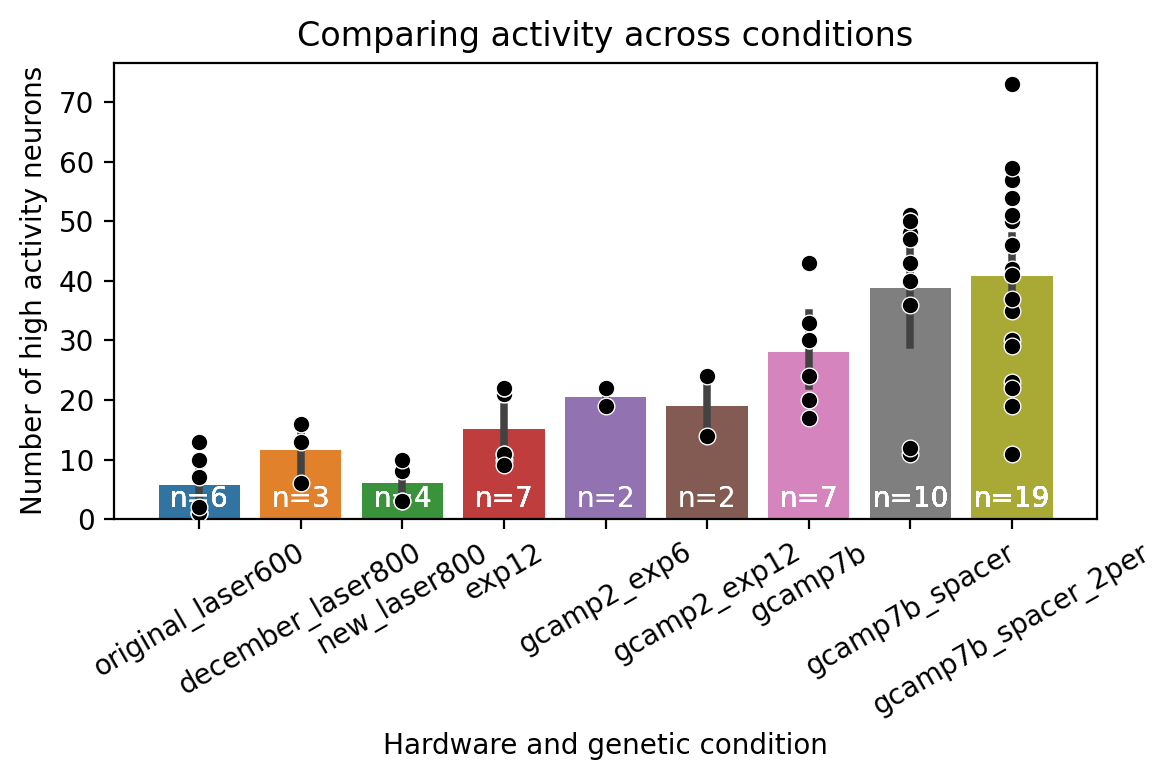

In [54]:
plt.figure(dpi=200)

to_plot = 'high'
df = df_all

ax = sns.barplot(data=df, y=to_plot, x='title')
for index, row in df.iterrows():
    ax.text(row.title, 2, f"n={(df['title'] == row.title).value_counts()[True]}",
            color='white', ha='center')
    
sns.scatterplot(data=df, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Hardware and genetic condition")
plt.xticks(rotation=30)
plt.ylabel(f"Number of {to_plot} activity neurons")
plt.title("Comparing activity across conditions")
plt.tight_layout()

if to_save:
    plt.savefig('hardware_quantifications/dataset_types_high_activity_with_gcamp7b_and_spacers.png')

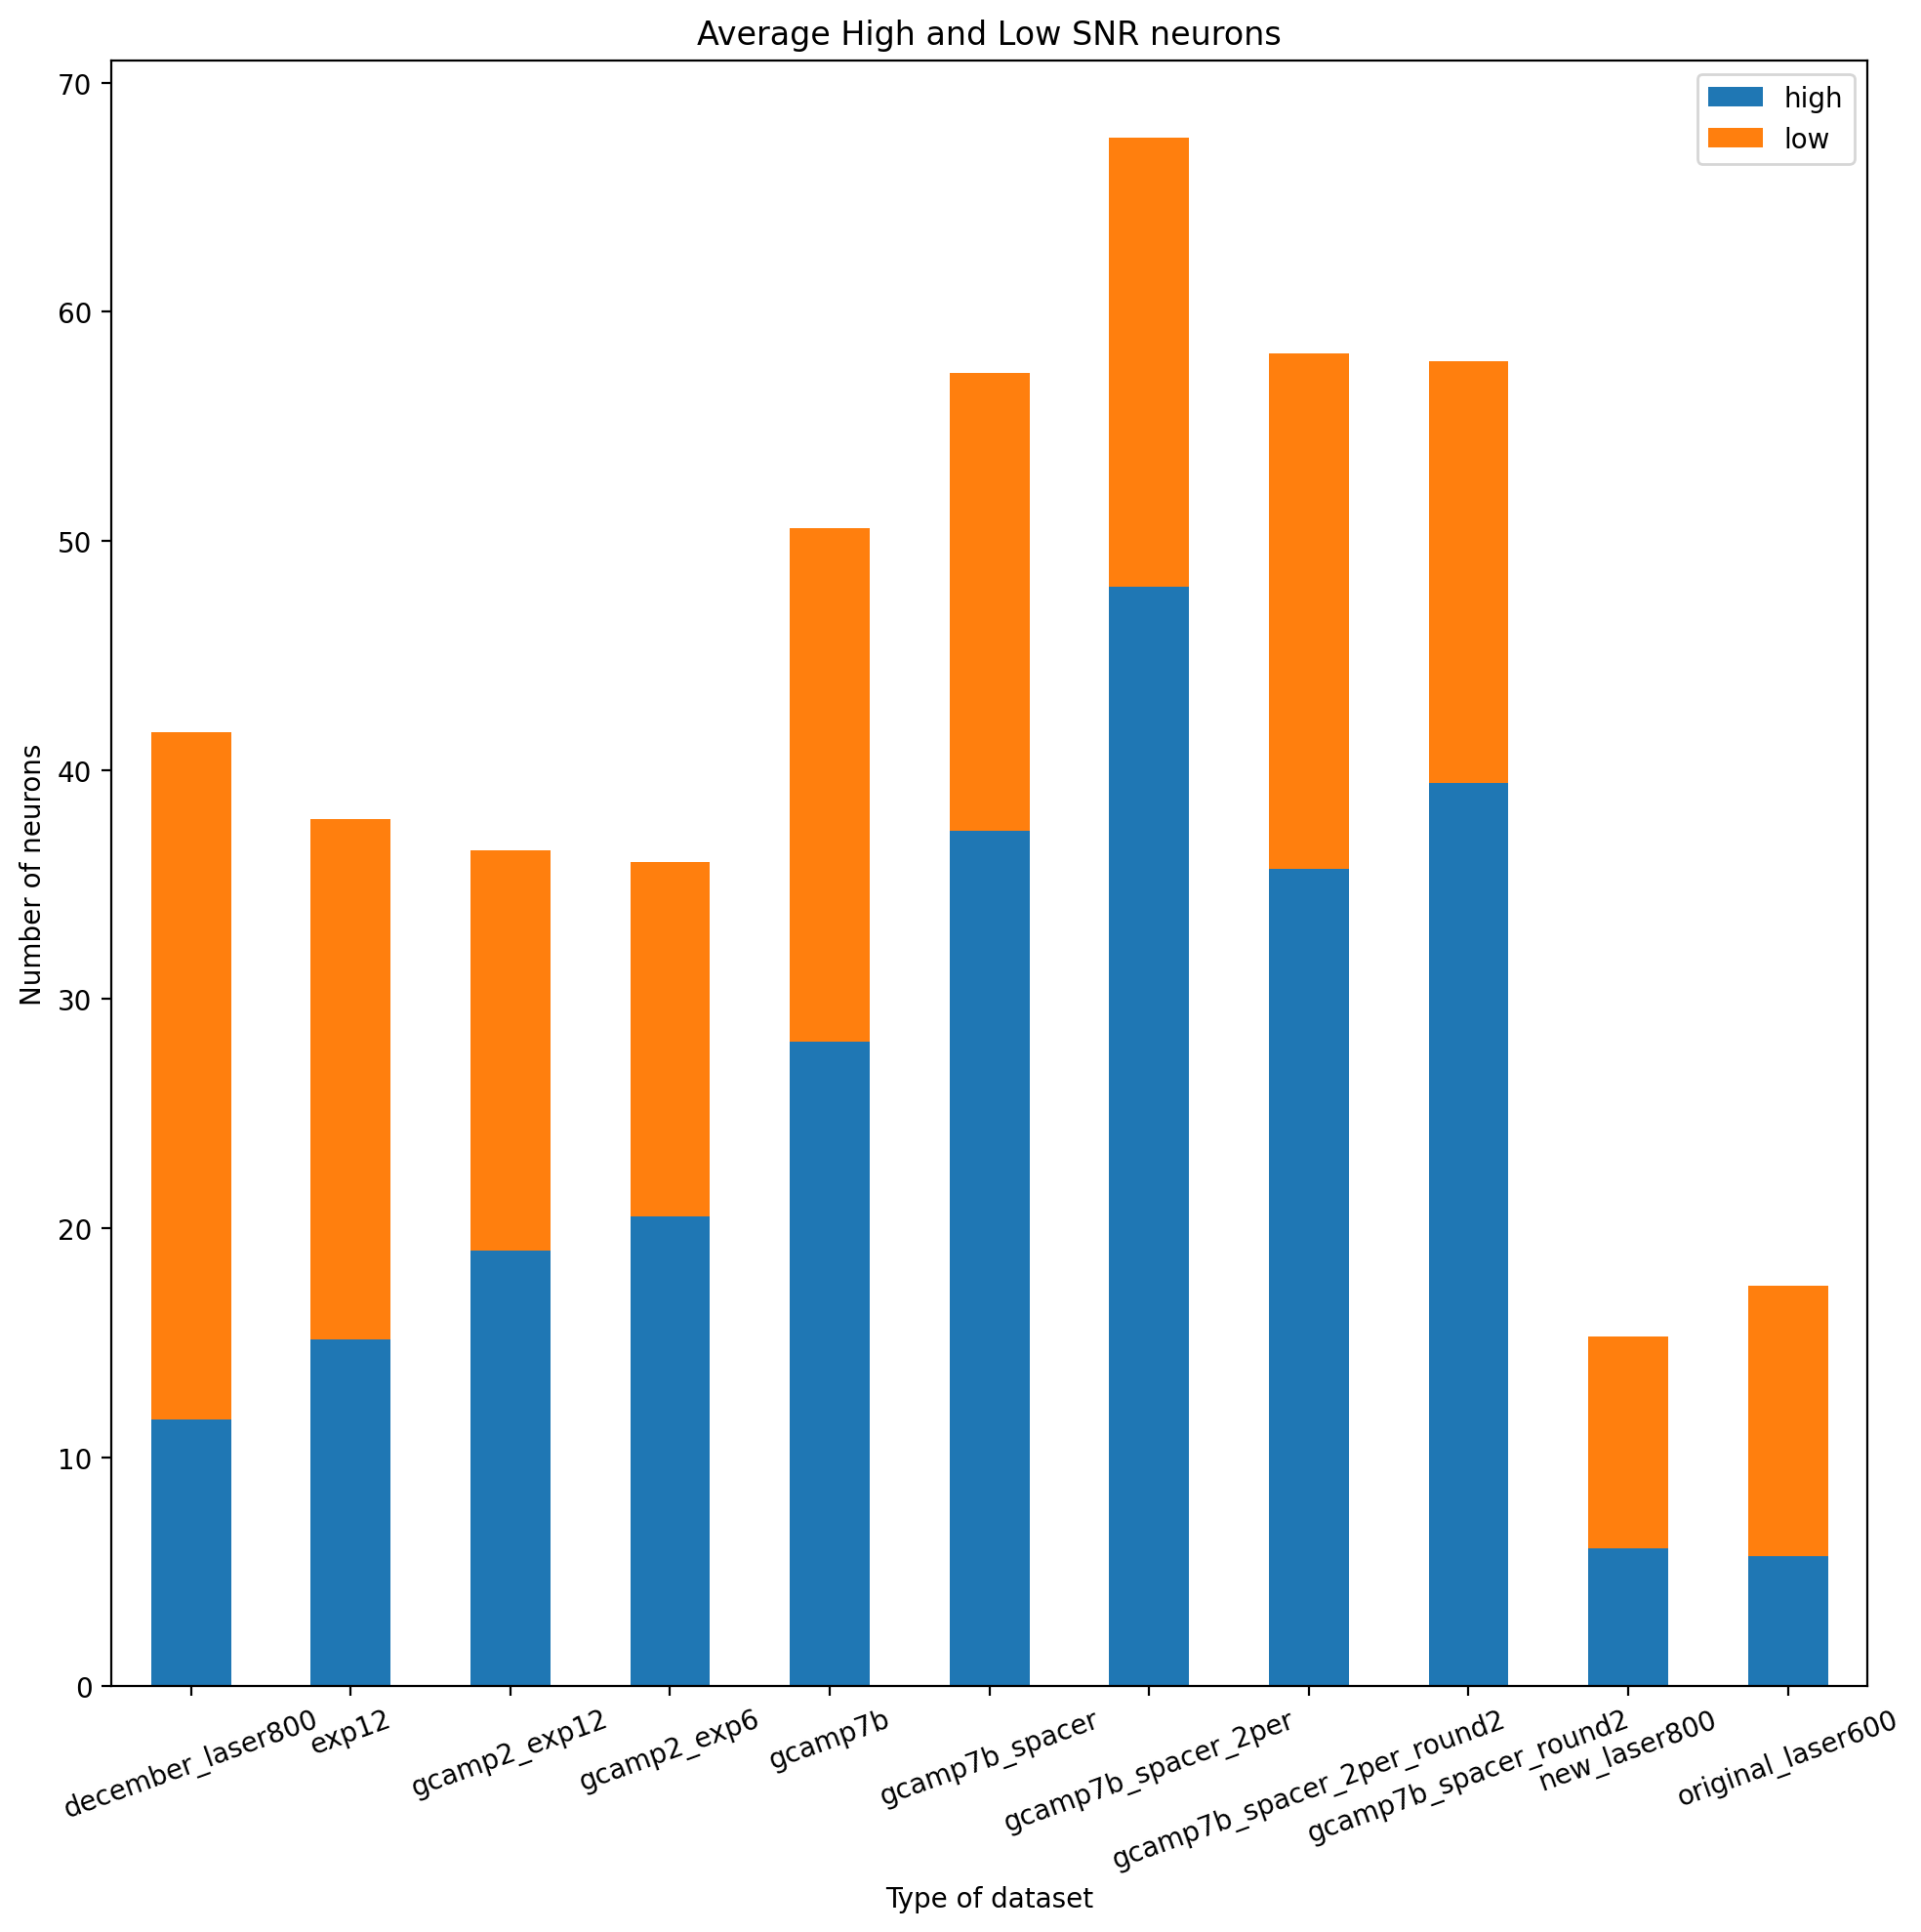

In [55]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

to_plot = 'low'
df = df_all

df_to_plot = df.drop(columns=['possible']).groupby('title')
df_to_plot.mean().plot(kind='bar', stacked=True, ax=ax)

plt.xlabel("Type of dataset")
plt.ylabel(f"Number of neurons")
plt.title("Average High and Low SNR neurons")
plt.xticks(rotation=20)

plt.tight_layout()
if to_save:
    plt.savefig('hardware_quantifications/dataset_types_high_low_stacked_activity_gcamp7b_and_spacers.png')

# Number of well-tracked neurons

In [56]:
projects_to_compare = dict(
    gcamp7b = all_projects_gcamp7b,
    gcamp7b_spacer = all_projects_spacer,
    gcamp7b_spacer_round2 = all_projects_spacer_round2,
    gcamp7b_spacer_round3 = all_projects_spacer_round3,
    gcamp7b_spacer_2per = all_projects_spacer_2per,
    gcamp7b_spacer_2per_round2 = all_projects_spacer_2per_round2
)

num_tracked_dict = {}
i = 0
thresholds = [0.95, 0.9, 0.75, 0.5]
for key, project_list in tqdm(projects_to_compare.items()):
    for p in project_list:
        for t in thresholds:
            new_key = f"{key}_{i}"
            try:
                num_tracked = len(p.well_tracked_neuron_names(t))
                num_tracked_dict[new_key] = [num_tracked, t, key]
                i += 1
            except AttributeError:
                pass
        
df_tracked = pd.DataFrame(num_tracked_dict).T
df_tracked.columns = ["num_tracked", "tracking_threshold", "dataset_title"]

  0%|          | 0/6 [00:00<?, ?it/s]

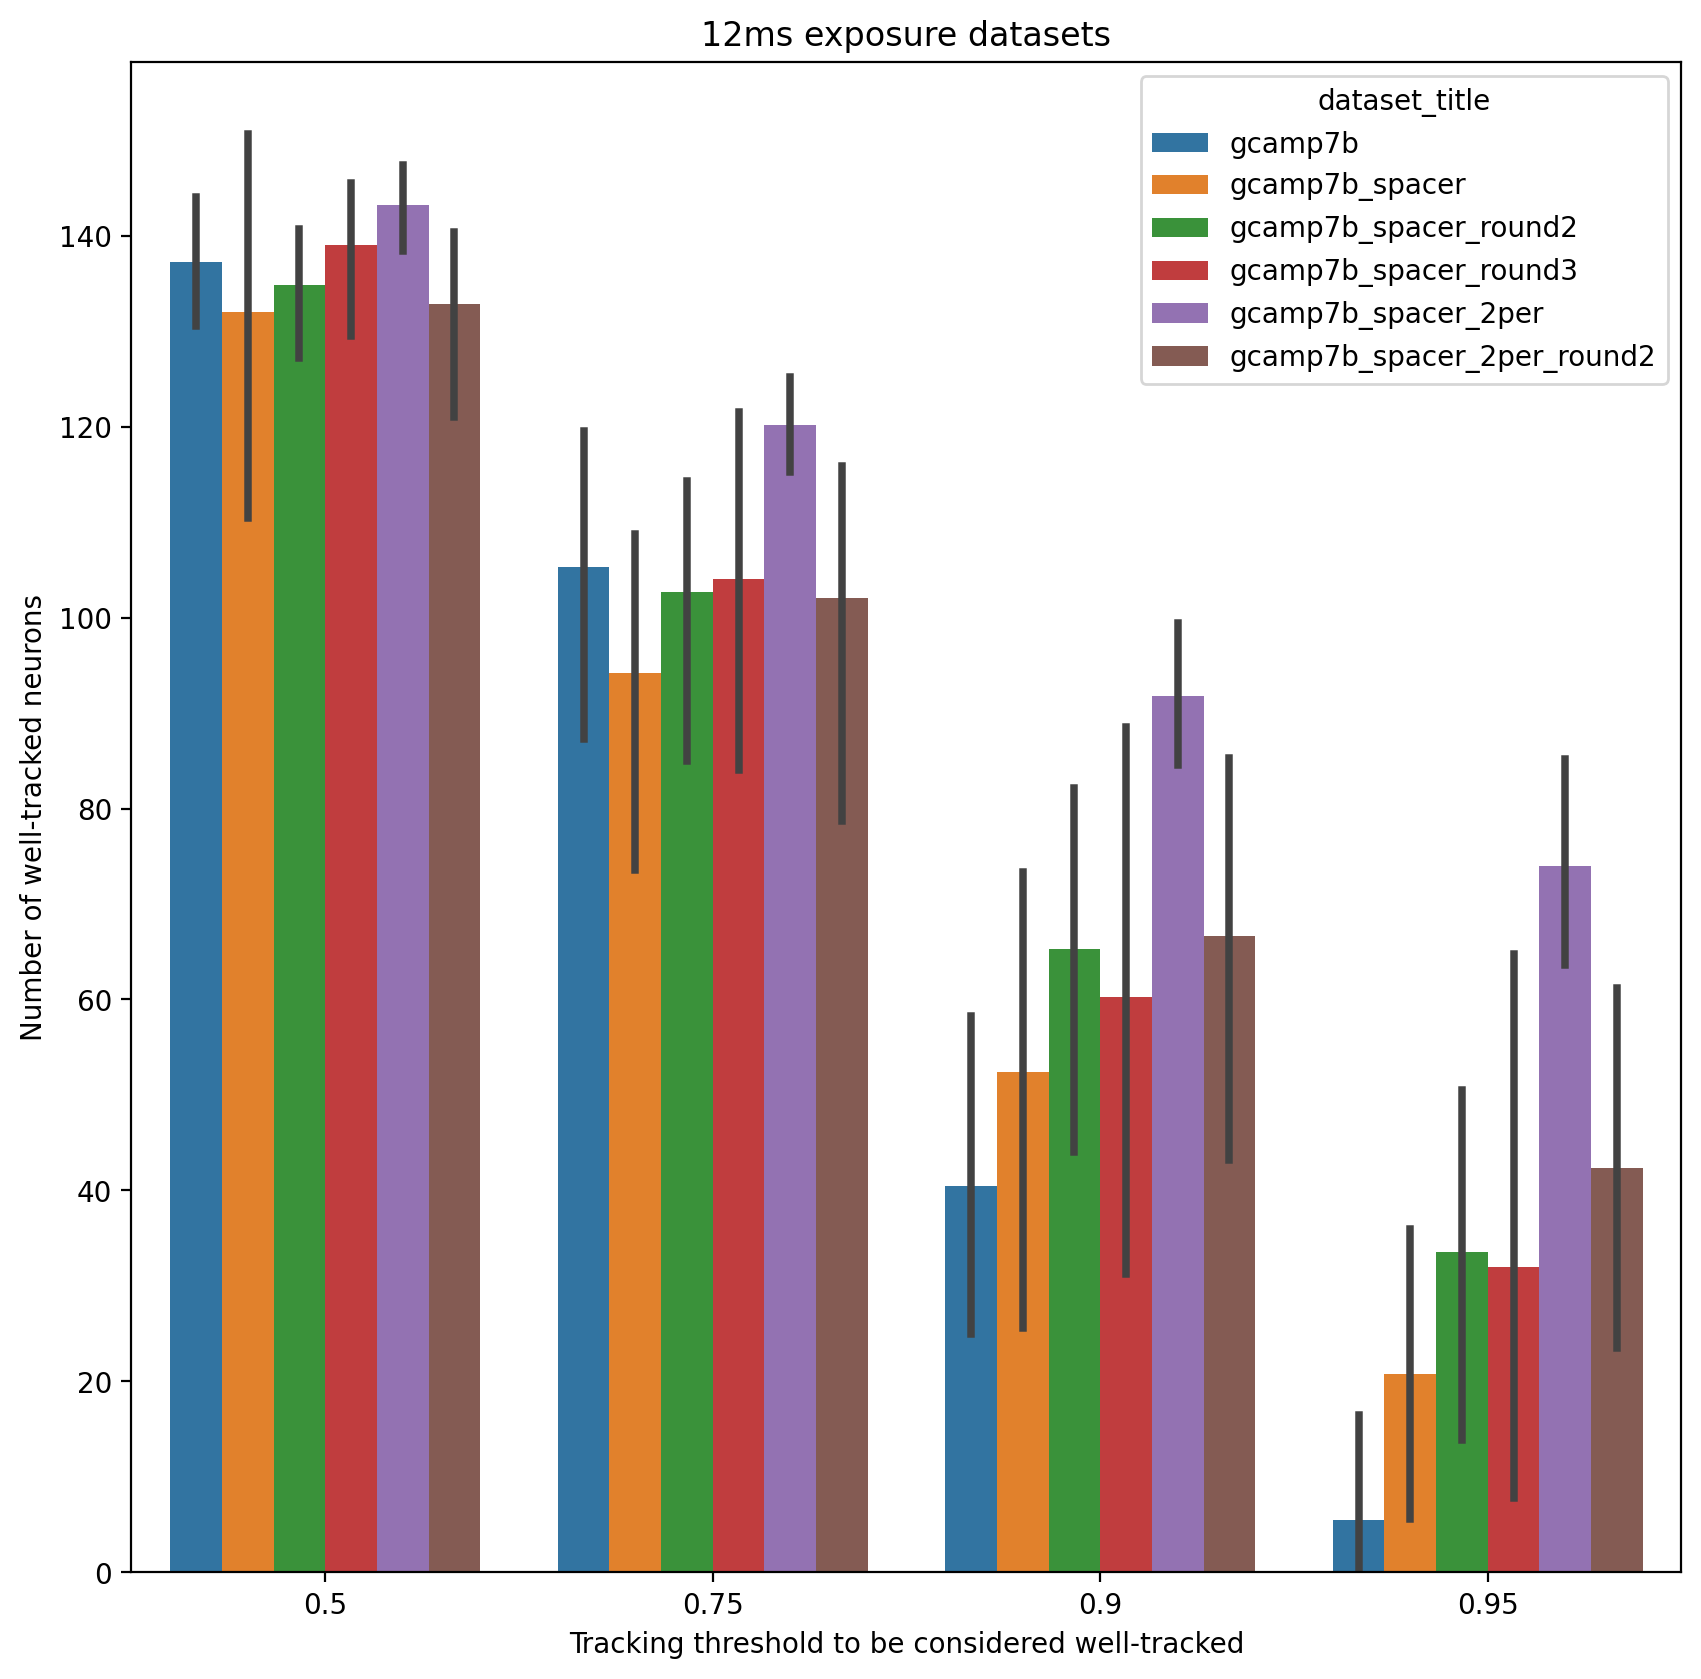

In [57]:
plt.figure(figsize=(10, 10), dpi=200)

to_plot = "num_tracked"
df = df_tracked

ax = sns.barplot(data=df, y=to_plot, x='tracking_threshold', hue='dataset_title')
# for index, row in df.iterrows():
#     ax.text(row.title, 2, f"n={(df['title'] == row.title).value_counts()[True]}",
#             color='white', ha='center')
# sns.scatterplot(data=df, y=to_plot, x='title', hue='tracking_threshold', 
#                 legend=False, zorder=10, color='k')
plt.xlabel("Tracking threshold to be considered well-tracked")
# plt.xticks(rotation=10)
plt.ylabel(f"Number of well-tracked neurons")
plt.title("12ms exposure datasets")

if to_save:
    plt.savefig('hardware_quantifications/well_tracked_neurons.png')

# Speed of the worms, and see if this is correlated to anything

In [58]:
projects_to_compare = dict(
    gcamp7b = all_projects_gcamp7b,
    gcamp7b_spacer = all_projects_spacer,
    gcamp7b_spacer_round2 = all_projects_spacer_round2,
    gcamp7b_spacer_round3 = all_projects_spacer_round3,
    gcamp7b_spacer_2per = all_projects_spacer_2per,
    gcamp7b_spacer_2per_round2 = all_projects_spacer_2per_round2
)

avg_speed_dict = {}
i = 0
for key, project_list in tqdm(projects_to_compare.items()):
    for p in tqdm(project_list, leave=False):
        new_key = f"{key}_{i}"
        avg_speed = np.nanmean(p.worm_posture_class.worm_speed_fluorescence_fps)
        avg_speed_dict[new_key] = [avg_speed, key]
        i += 1
        
df_speed = pd.DataFrame(avg_speed_dict).T
df_speed.columns = ["speed", "dataset_title"]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

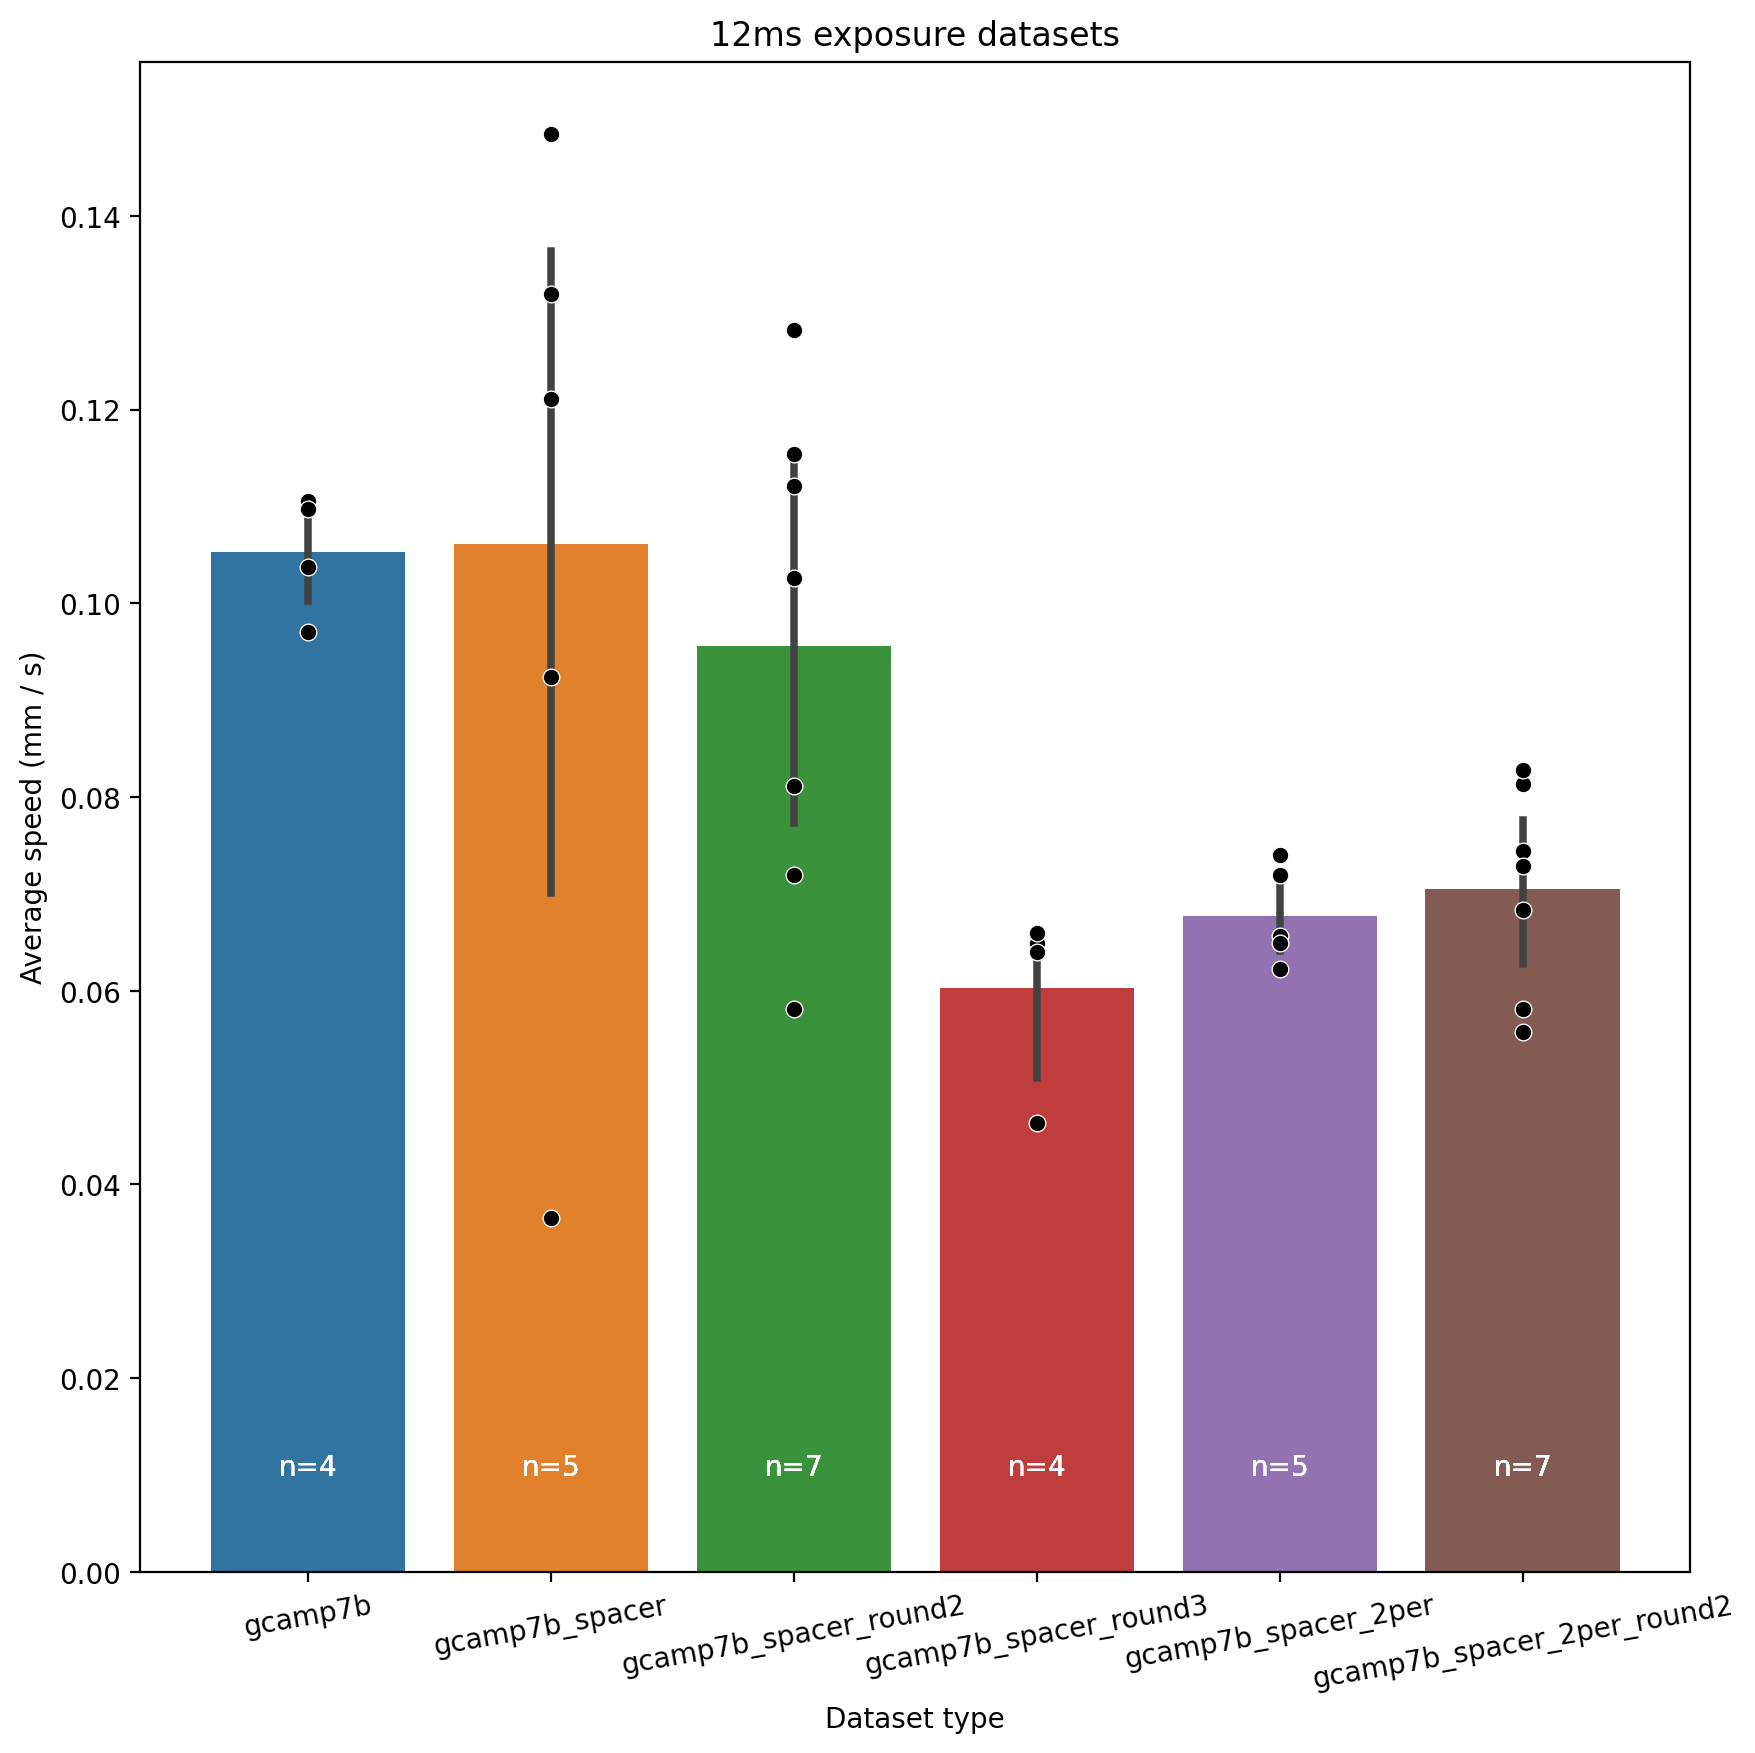

In [59]:
plt.figure(figsize=(10, 10), dpi=200)

to_plot = "speed"
df = df_speed

ax = sns.barplot(data=df, y=to_plot, x='dataset_title')
plt.xlabel("Dataset type")
for index, row in df.iterrows():
    ax.text(row.dataset_title, 0.01, f"n={(df['dataset_title'] == row.dataset_title).value_counts()[True]}",
            color='white', ha='center')
sns.scatterplot(data=df, y=to_plot, x='dataset_title',
                legend=False, zorder=10, color='k')
plt.xticks(rotation=10)
plt.ylabel(f"Average speed (mm / s)")
plt.title("12ms exposure datasets")

if to_save:
    plt.savefig('hardware_quantifications/average_worm_speed.png')

# Count number of reversals

In [60]:
from wbfm.utils.external.utils_pandas import get_contiguous_blocks_from_column

In [61]:
projects_to_compare = dict(
    gcamp7b = all_projects_gcamp7b,
    gcamp7b_spacer = all_projects_spacer,
    gcamp7b_spacer_round2 = all_projects_spacer_round2,
    gcamp7b_spacer_round3 = all_projects_spacer_round3,
    gcamp7b_spacer_2per = all_projects_spacer_2per,
    gcamp7b_spacer_2per_round2 = all_projects_spacer_2per_round2
)

num_rev_dict = {}
for key, project_list in tqdm(projects_to_compare.items()):
    i = 0
    for p in tqdm(project_list, leave=False):
        new_key = f"{key}_{i}"
        beh_annotations = p.worm_posture_class.behavior_annotations_fluorescence_fps
        try:
            num_rev = len(get_contiguous_blocks_from_column(beh_annotations==1, already_boolean=True)[0])
            num_rev_dict[new_key] = [num_rev, key]
            i += 1
        except AttributeError:
            pass
        
df_rev = pd.DataFrame(num_rev_dict).T
df_rev.columns = ["num_reversals", "dataset_title"]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

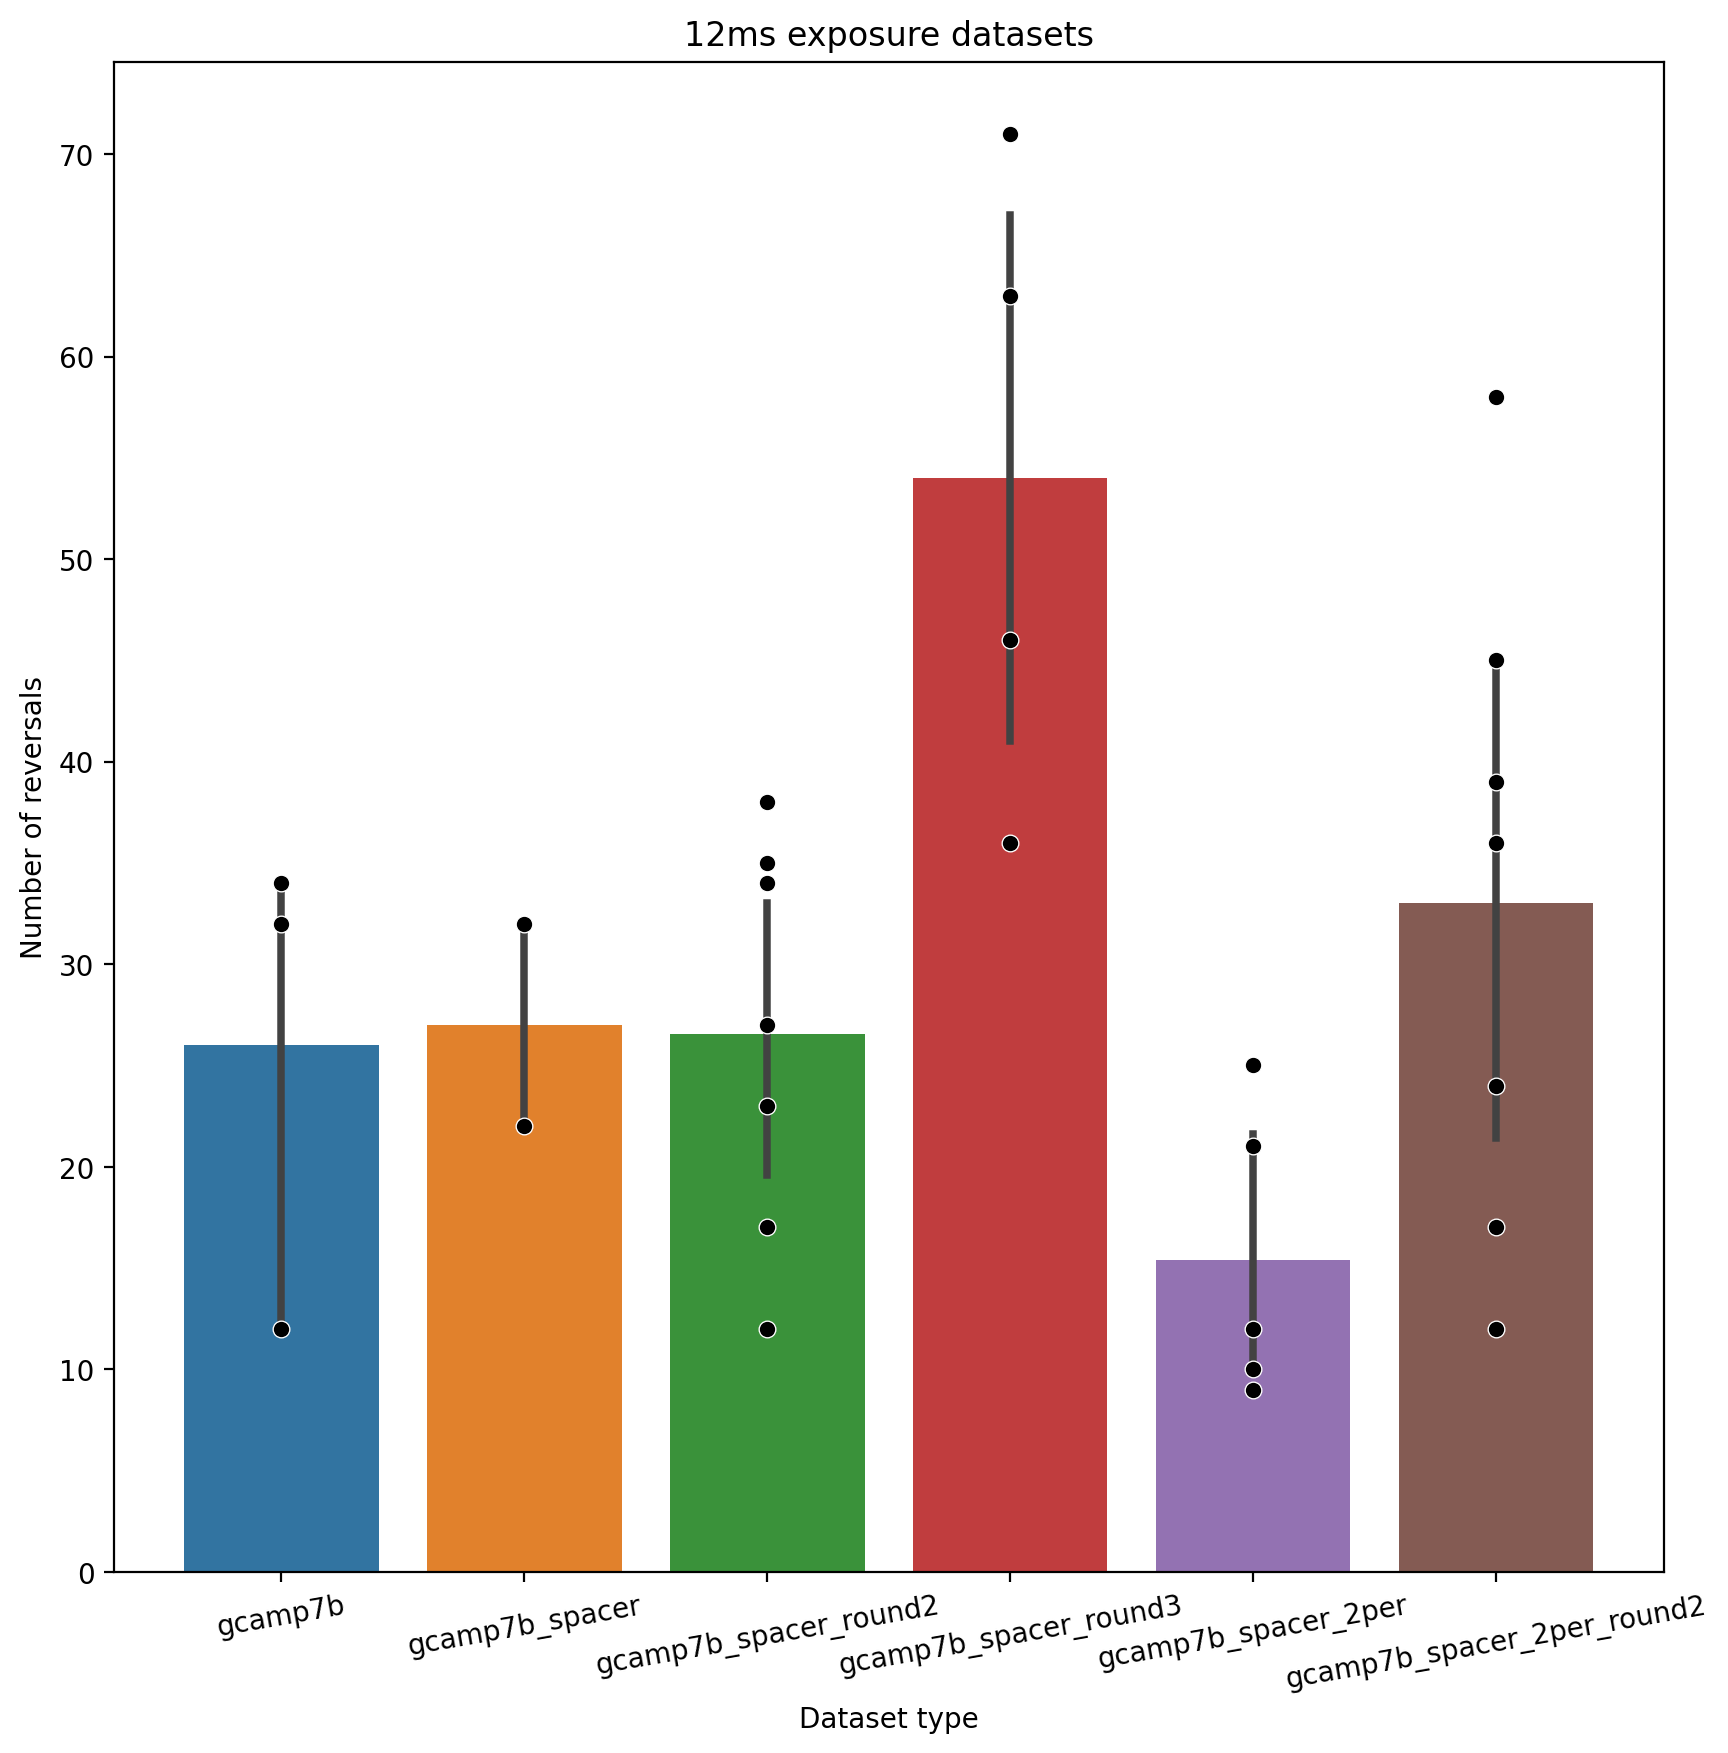

In [63]:
plt.figure(figsize=(10, 10), dpi=200)

to_plot = "num_reversals"
df = df_rev

ax = sns.barplot(data=df, y=to_plot, x='dataset_title')
plt.xlabel("Dataset type")
# for index, row in df.iterrows():
#     ax.text(row.dataset_title, 2, f"n={(df['dataset_title'] == row.dataset_title).value_counts()[True]}",
#             color='white', ha='center')
sns.scatterplot(data=df, y=to_plot, x='dataset_title',
                legend=False, zorder=10, color='k')
plt.xticks(rotation=10)
plt.ylabel(f"Number of reversals")
plt.title("12ms exposure datasets")

if to_save:
    plt.savefig('hardware_quantifications/number_of_reversals.png')

# Pairplots to see correlations

In [64]:
# Redo calculations to make sure there is only a single number for 
projects_to_compare = dict(
    gcamp7b = all_projects_gcamp7b,
    gcamp7b_spacer = all_projects_spacer,
    gcamp7b_spacer_round2 = all_projects_spacer_round2,
    gcamp7b_spacer_round3 = all_projects_spacer_round3,
    gcamp7b_spacer_2per = all_projects_spacer_2per,
    gcamp7b_spacer_2per_round2 = all_projects_spacer_2per_round2
)

avg_speed_dict = {}
for key, project_list in tqdm(projects_to_compare.items()):
    i = 0
    for p in tqdm(project_list, leave=False):
        new_key = f"{key}_{i}"
        avg_speed = np.nanmean(p.worm_posture_class.worm_speed_fluorescence_fps)
        avg_speed_dict[new_key] = [avg_speed, key]
        i += 1
        
df_speed = pd.DataFrame(avg_speed_dict).T
df_speed.columns = ["speed", "dataset_title"]

num_tracked_dict = {}
thresholds = [0.9]
for key, project_list in tqdm(projects_to_compare.items()):
    i = 0
    for p in project_list:
        for t in thresholds:
            new_key = f"{key}_{i}"
            try:
                num_tracked = len(p.well_tracked_neuron_names(t))
                num_tracked_dict[new_key] = [num_tracked, t, key]
                i += 1
            except AttributeError:
                pass
        
df_tracked = pd.DataFrame(num_tracked_dict).T
df_tracked.columns = ["num_tracked", "tracking_threshold", "dataset_title"]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [65]:
df_pairplot = df_all.join(df_speed, how='outer').join(df_tracked[['num_tracked', 'tracking_threshold']], how='outer').join(df_rev[['num_reversals']], how='outer')
df_pairplot.dropna(axis=0, inplace=True) # Drop old datasets that I didn't do speed calculations for

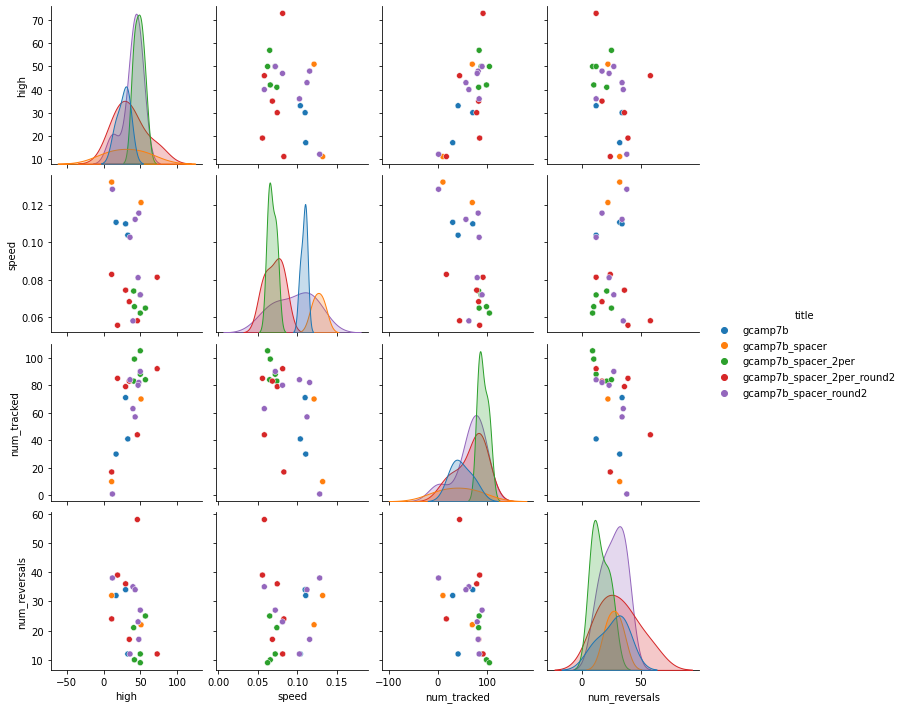

In [67]:
sns.pairplot(df_pairplot, vars=['high', 'speed', 'num_tracked', 'num_reversals'], hue='title')

if to_save:
    plt.savefig('hardware_quantifications/pairplot_speed-num_tracked-high_activity.png')

In [ ]:
# tmp = df_all.join(df_speed, how='outer').join(df_tracked[['num_tracked', 'tracking_threshold']], how='outer').join(df_rev[['num_reversals']])
# tmp